# Car Price Prediction
Regression | Gradient Boosting | Computational complexity

***

## Project Description

### The problem

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. With access to historical data: technical specifications, trim versions, and prices, build the model to determine the value.

### Conditions

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

### Data description

**Features**

- *DateCrawled* — date profile was downloaded from the database
- *VehicleType* — vehicle body type
- *RegistrationYear* — vehicle registration year
- *Gearbox* — gearbox type
- *Power* — power (hp)
- *Model* — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- *RegistrationMonth* — vehicle registration month
- *FuelType* — fuel type
- *Brand* — vehicle brand
- *NotRepaired* — vehicle repaired or not
- *DateCreated* — date of profile creation
- *NumberOfPictures* — number of vehicle pictures
- *PostalCode* — postal code of profile owner (user)
- *LastSeen* — date of the last activity of the user

**Target**

*Price* — price (Euro)

***

## EDA and preprocessing

### Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

plt.rcParams["figure.figsize"] = (9, 4)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Read and look at the data

In [3]:
data = pd.read_csv("datasets/car_data.csv", 
                   parse_dates=["DateCrawled","DateCreated","LastSeen"])

data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-07-04 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-05-04 12:47:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Mileage,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


- The `RegistrationYear` column will be useful for determining car's value, but the `RegistrationMonth` might be redundant;
- There are extreme values in the `RegistrationYear` and the `Power` columns that unlikely are true;
- The `NumberOfPictures` column contains only zeros;
- In the `Price` column, there are zero values. The model shouldn't learn them to avoid zero-price suggestions.
- Some columns have missing values;

### Data coverage period

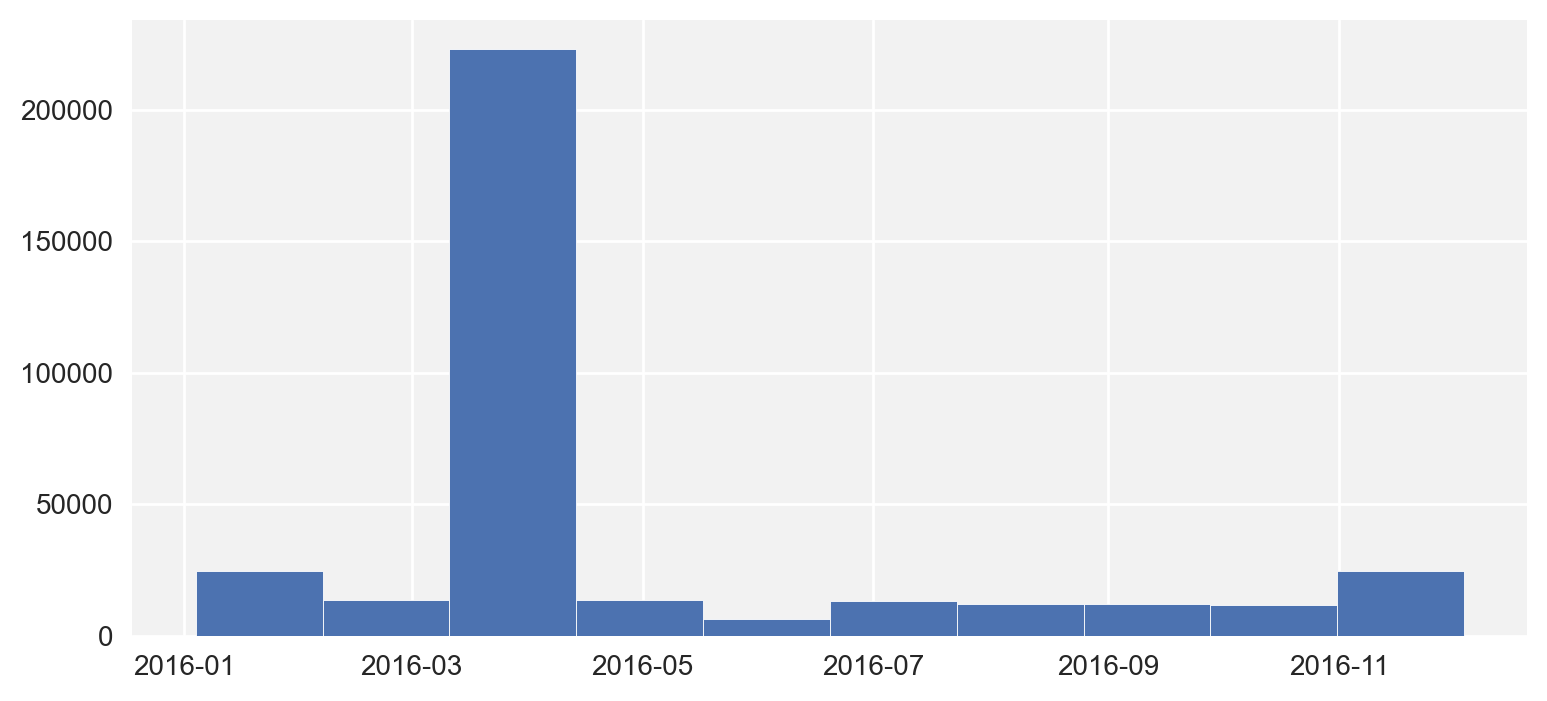

In [6]:
# see the range of the `DataCrawled` column
data["DateCrawled"].hist();

The data was collected for the period of 2016, with the most values from April.

### Outliers

#### Registration year

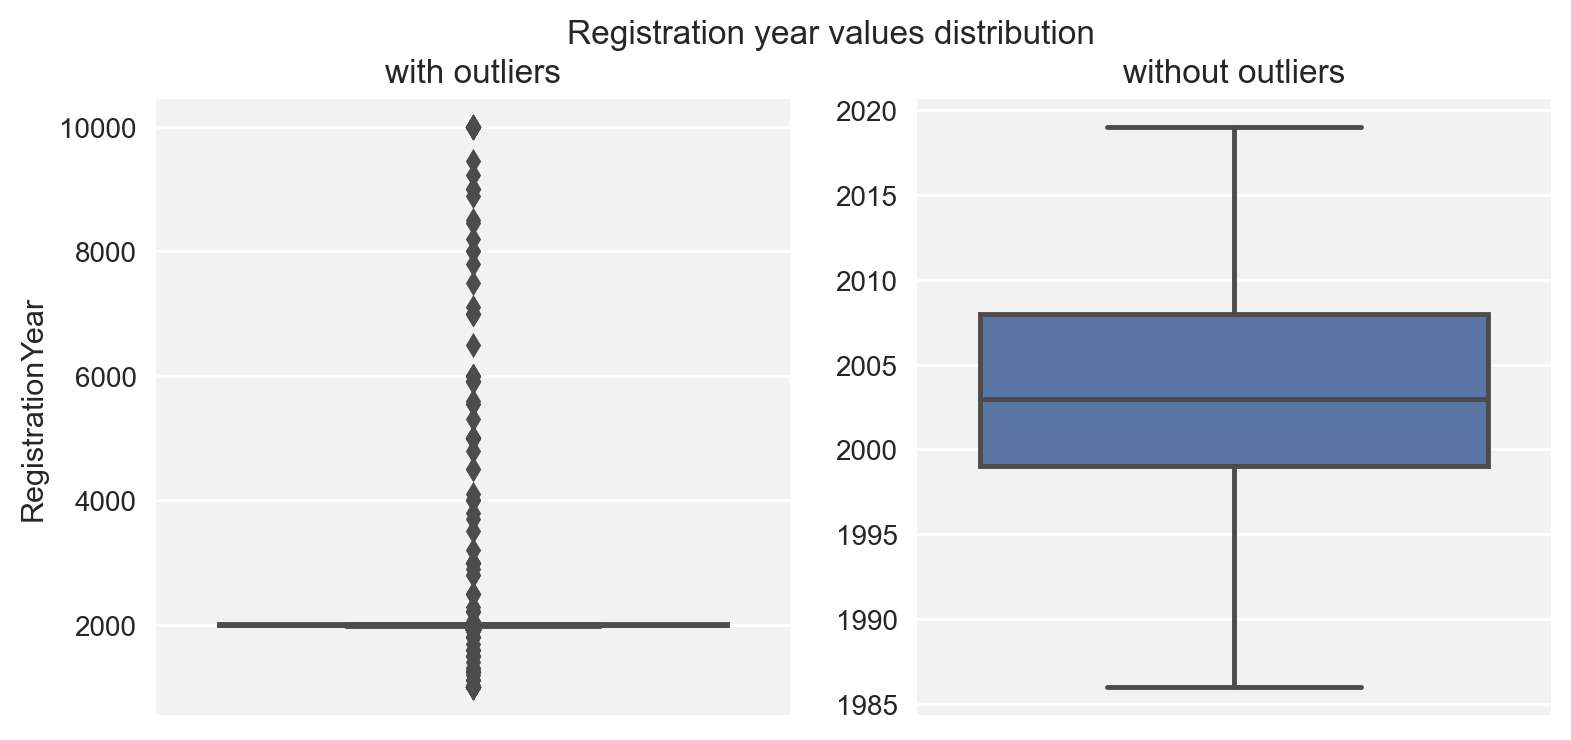

In [7]:
# create a box plot to look closer on the outliers
fig, axs = plt.subplots(1,2)
plt.suptitle("Registration year values distribution")

ax = axs[0]
sns.boxplot(y=data["RegistrationYear"], ax=ax)
ax.set(title="with outliers")

ax = axs[1]
sns.boxplot(y=data["RegistrationYear"], ax=ax, showfliers=False)
ax.set(title="without outliers", ylabel="");

From `1985` to `2020` looks like a reasonable range for vehicle registration dates, but we also remember that the data was collected in 2016, hence the year of any vehicle registration cannot be more than that.

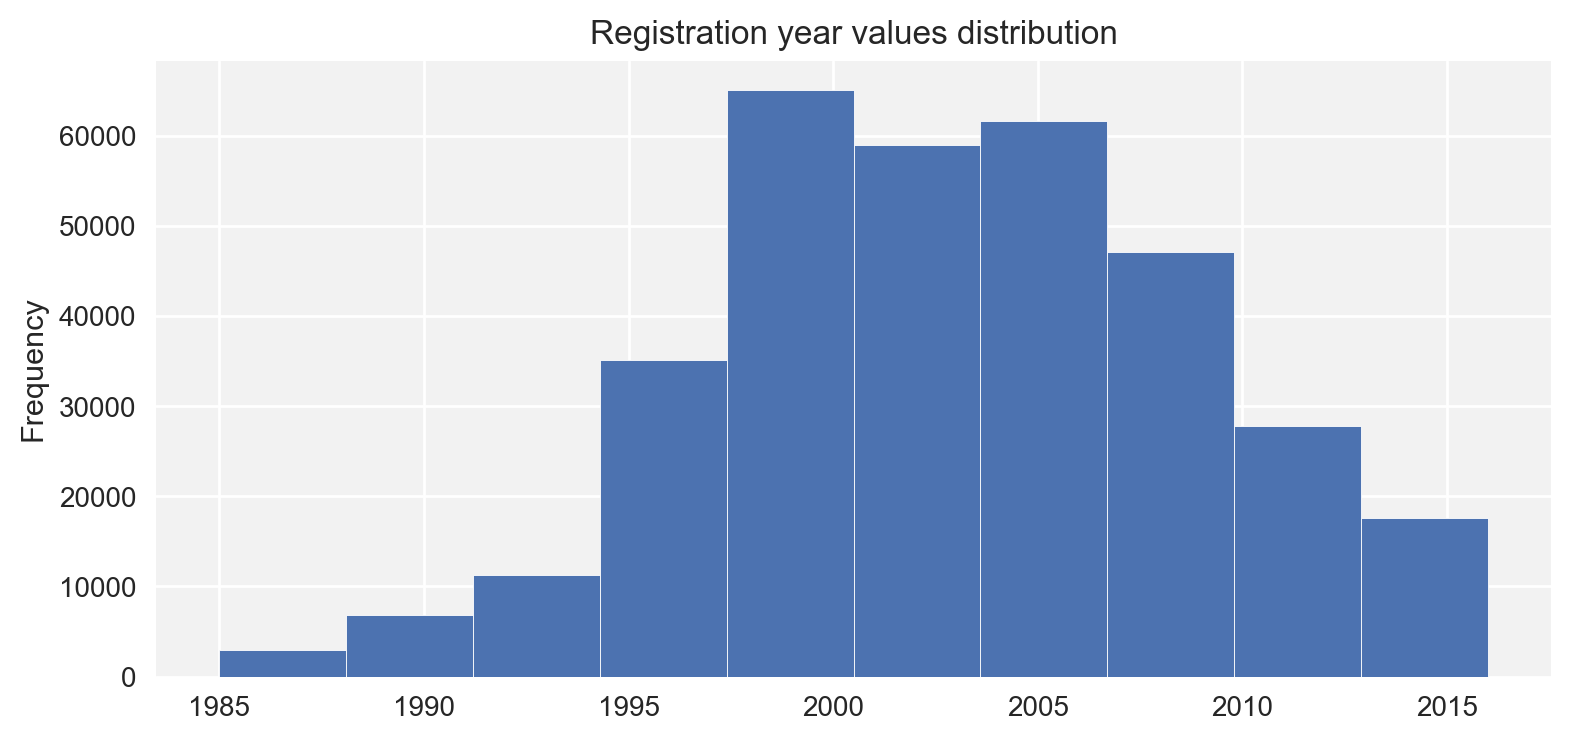

In [8]:
# filter out extreme values
data = data.query("1984 < RegistrationYear < 2017")

# see the distribution without extremes
data["RegistrationYear"].plot(kind="hist", 
                              title="Registration year values distribution");

#### Power

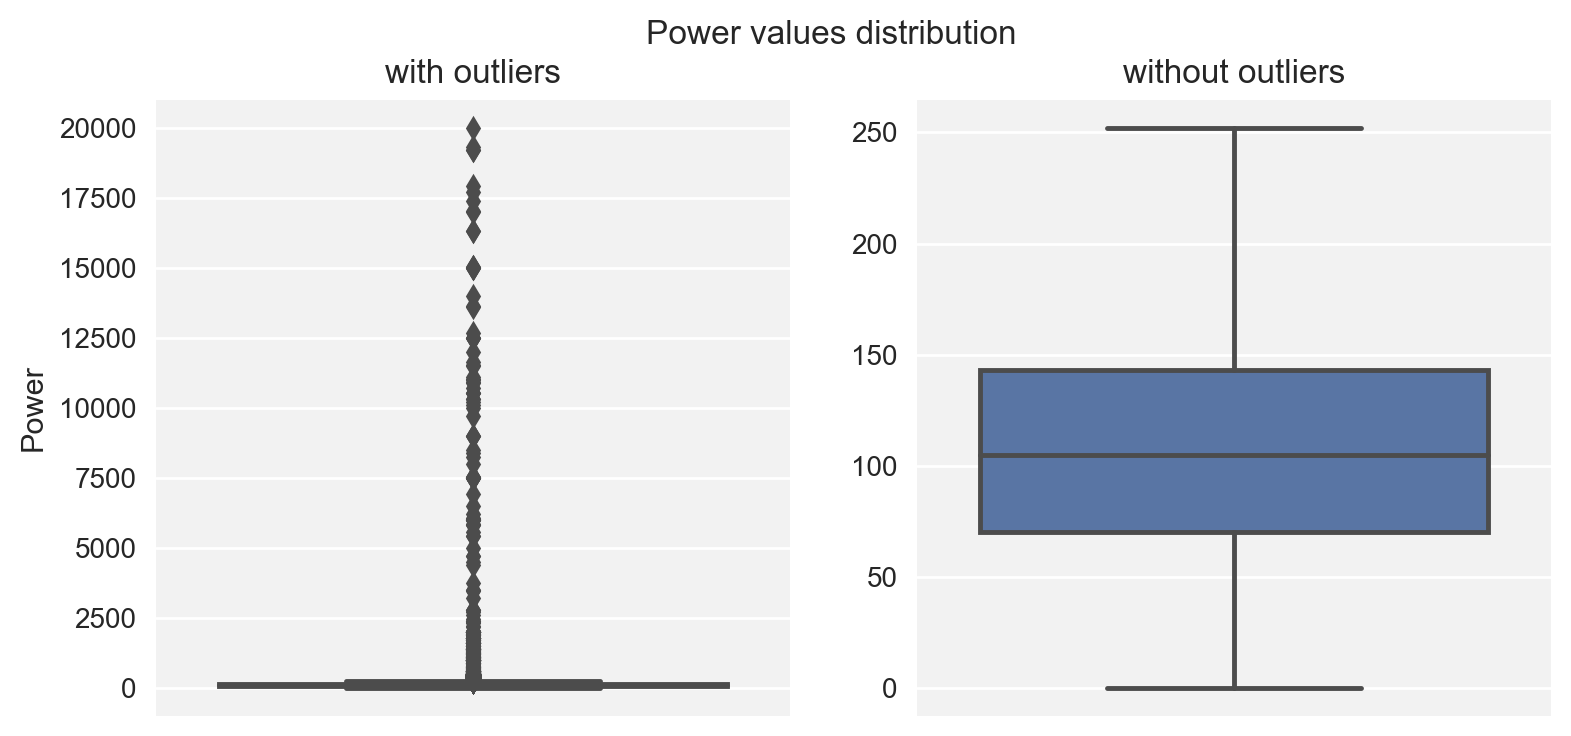

In [9]:
# create a box plot to see where outliers begin
fig, axs = plt.subplots(1,2)
plt.suptitle("Power values distribution")

ax = axs[0]
sns.boxplot(y=data["Power"], ax=ax)
ax.set(title="with outliers")

ax = axs[1]
sns.boxplot(y=data["Power"], ax=ax, showfliers=False)
ax.set(title="without outliers", ylabel="");

The upper boundary of 250 horse powers looks okay, but a vehicle with zero HP doesn't make sense.

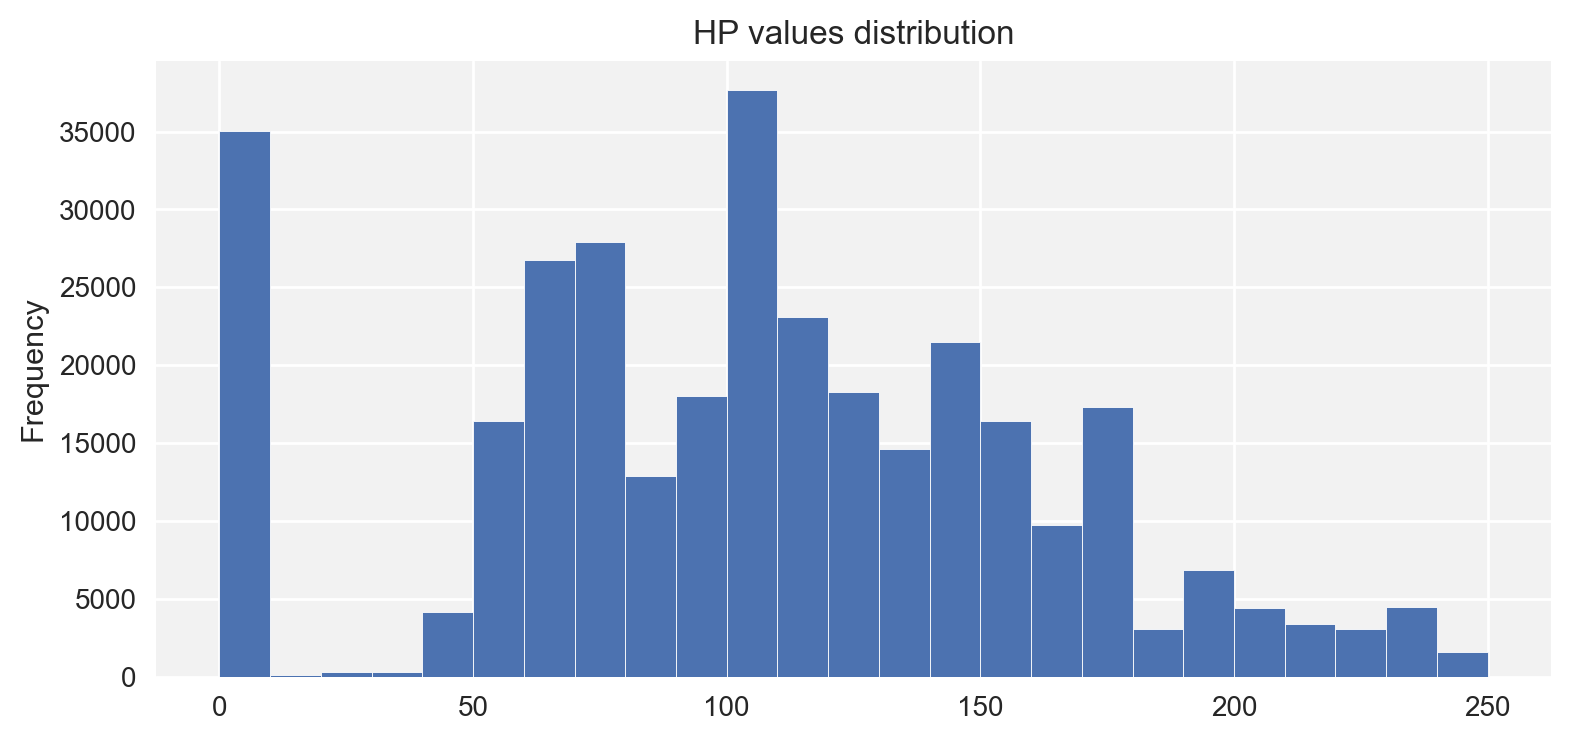

In [10]:
# cut off the upper boundary of 250 HP
data = data.query("Power <= 250")
data["Power"].plot(kind="hist", bins=25, title="HP values distribution");

Let us assume that 20 HP is a minimum sensible value.

In [11]:
data = data.query("Power >= 20")

#### Price

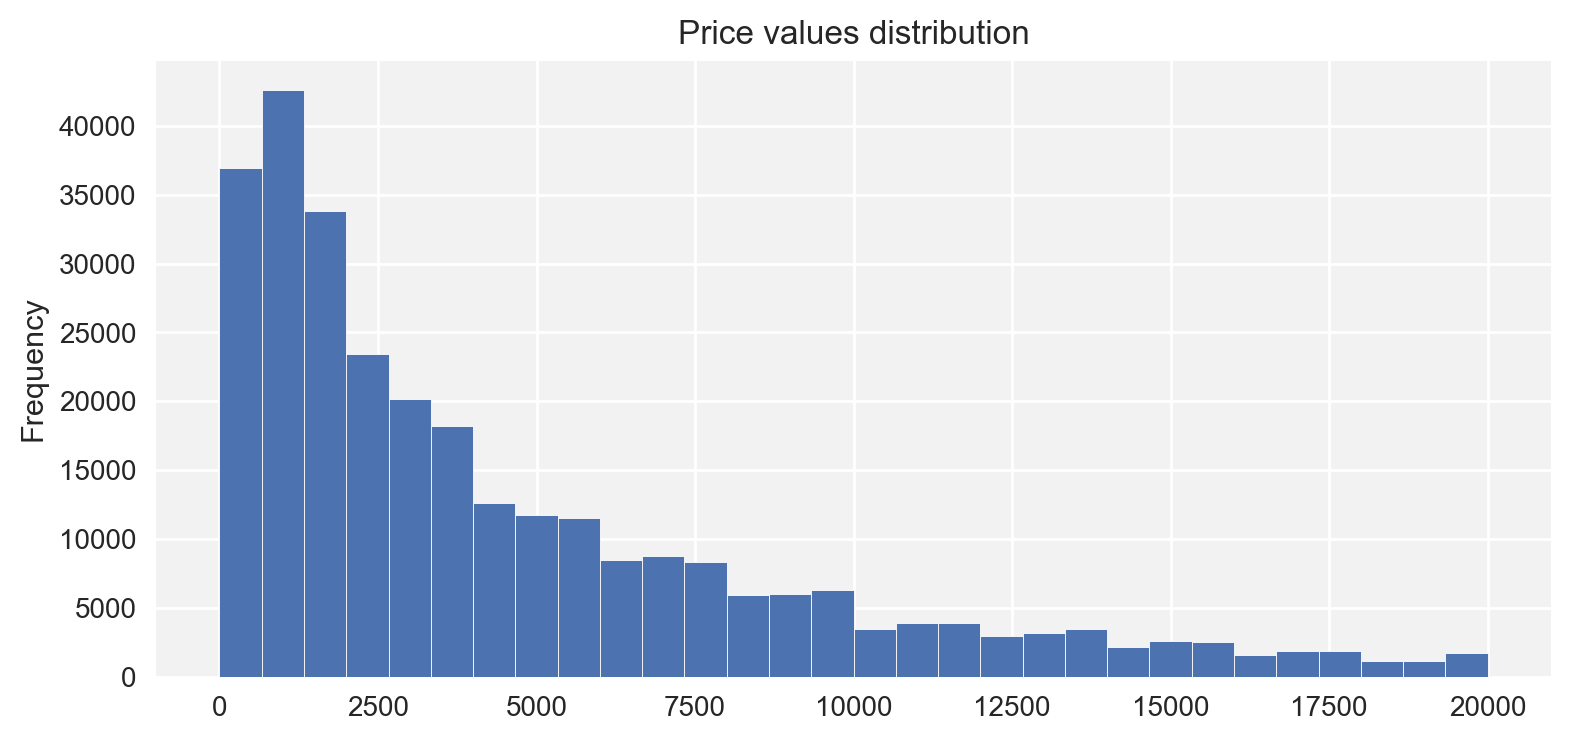

In [12]:
# see the price values distribution
data["Price"].plot(kind="hist", title="Price values distribution", bins=30);

Lets take $50 as the minimum reasonable price for a vehicle.

In [13]:
# cut off vehicles with the price less than $50
data = data.query("Price >= 50")

### Missing values, duplicates

In [14]:
# see the proportion of missing values
(data.isna().sum() / data.shape[0] * 100).round(2)

DateCrawled           0.00
Price                 0.00
VehicleType           3.72
RegistrationYear      0.00
Gearbox               1.79
Power                 0.00
Model                 3.48
Mileage               0.00
RegistrationMonth     0.00
FuelType              5.22
Brand                 0.00
NotRepaired          14.43
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

The columns with missing values are categorical and not as essential for the analysis as `Price`, `RegistrationYear`, and `Mileage`. Even if a customer won't specify these parameters,  we would still want the model to predict the price of the vehicle. With that said, missing values can be filled in with a placeholder like `unknown`.

In [15]:
# fill in missing values
data = data.fillna("unknown")

In [16]:
# check for duplicated rows
data.duplicated().sum()

247

In [17]:
# drop duplicated rows
data.drop_duplicates(inplace=True)

# see how much data left
data.shape[0]

285097

***

## ML part

### Setup

In [18]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [19]:
seed = 54321

### Prepare features

#### Split

In [20]:
# firts exclude the unnecesary columns from the features dataframe
X = data.drop(columns=["NumberOfPictures","DateCrawled","DateCreated",
                       "LastSeen","RegistrationMonth", "PostalCode", "Price"])
y = data["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                    random_state=seed)

print(f"train shape: {X_train.shape}")
print(f"test shape:  {X_test.shape}")

train shape: (228077, 9)
test shape:  (57020, 9)


#### Encode

In [21]:
# create two lists with the names of categorical and numerical columns
num_cols = ["RegistrationYear", "Power", "Mileage"]
cat_cols = ["VehicleType","Gearbox", "Model","FuelType","Brand","NotRepaired"]

In [22]:
# encode categorical features for linear models
ohe = OneHotEncoder().fit(X_train[cat_cols])
X_train_ohe = ohe.transform(X_train[cat_cols]).toarray()
X_test_ohe = ohe.transform(X_test[cat_cols]).toarray()

# encoding for tree-based models
ord_encoder = OrdinalEncoder().fit(X_train[cat_cols])
X_train_ord = ord_encoder.transform(X_train[cat_cols])
X_test_ord = ord_encoder.transform(X_test[cat_cols])

#### Standardize

In [23]:
# standardize numeric feautures
train_mean = X_train[num_cols].mean()
train_std = X_train[num_cols].std()

X_train_std = (X_train[num_cols] - train_mean) / train_std
X_test_std = (X_test[num_cols] - train_mean) / train_std

#### Combine

In [28]:
# combine everithing back into one dataframe
X_train = np.column_stack([X_train_ohe, X_train_std])
X_test = np.column_stack([X_test_ohe, X_test_std])

# dataframe for tree-based models
X_train_tree = np.column_stack([X_train_ord, X_train_std])
X_test_tree = np.column_stack([X_test_ord, X_test_std])

# see new shapes
print(f"train shape (one-hot encoded): {X_train.shape}")
print(f"train shape (encoded ordinal): {X_train_tree.shape}")

train shape (one-hot encoded): (228077, 313)
train shape (encoded ordinal): (228077, 9)


### Evaluation procedure

Each model will be evaluated using 5-fold cross validation, with RMSE as the key metric. We also need to save training and prediction time.

In [29]:
# define a function for models evaluation
def eval_model(model, X=X_train, y=y_train, cv=5,
               scoring="neg_root_mean_squared_error"):
  
  cv_result = cross_validate(model, X, y, cv=cv, scoring=scoring)
  
  score = -np.average(cv_result["test_score"])
  fit_time = np.average(cv_result["fit_time"])
  score_time = np.average(cv_result["score_time"])
  
  print("RMSE score: {:.0F}".format(score))
  print("Train time: {:.4f}".format(fit_time))
  print("Pred time: {:.4f}".format(score_time))
  
  return score, fit_time, score_time

In [30]:
# create a dictionary for storing different models' results
model_test_results = {}

### LinearRegression

In [31]:
# initialize the mdoel
lr = LinearRegression()

# evaluate the model using cross-validation
model_test_results["LinearRegression"] = eval_model(lr, X_train, y_train)

RMSE score: 2287
Train time: 1.8136
Pred time: 0.0046


### RandomForest

In [34]:
# evaluate a base model
rf = RandomForestRegressor(random_state=seed, n_estimators=20, n_jobs=-1)

# evaluate the forest using cross-validation
eval_model(rf, X_train_tree, y_train)

RMSE score: 1497
Train time: 0.9747
Pred time: 0.0479


(1496.6186898980711, 0.9747217178344727, 0.04794492721557617)

RandomForest yields much better results than a simple linear regression. See whether the model can be improved with via hyperparameters tuning.

Search for better hyperparameters

In [ ]:
# create a dictionary with parameters
max_depth = range(10, 31, 5)
min_sample_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
n_estimators = [20, 50, 100, 200]
params=dict(max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

# initialize the model again
rf = RandomForest(random_state=seed, n_jobs=-1)

grid_search = GridSearchCV(rf, params, cv=5, n_jobs=-1,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(X_train_tree, y_train)
print("Best: f% using %s" %(grid_searc))

In [ ]:
best_rmse = 999999
best_rf = None
bmd = 0
bmss = 0
bmsl = 0

for max_depth in [16, 18, 22, 24]:
    for min_samples_split in [5,10,15]:
        for min_samples_leaf in [1,2]:
            
            rf = RandomForestRegressor(random_state=state, n_estimators=10, # decrease the number of estimators
                           max_depth=max_depth,                             # to impove running time
                           min_samples_split=min_samples_split,
                           min_samples_leaf=min_samples_leaf
                          )
            
            print(f"params: m_depth {max_depth}, m_samp_spl {min_samples_split}, m_samp_leaf {min_samples_leaf}")
            # evaluate the forest using cross-validation
            rmse, train_time, pred_time = RMSE(rf, X_train_ord, y_train)
            print()
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_rf = rf
                bmd = max_depth
                bmss = min_samples_split
                bmsl = min_samples_leaf
                
print(f"Best params for RMSE {best_rmse:.0f}")
print(f"max_depth: {bmd} | min_samples_split: {bmss} min_samples_leaf: {bmsl}")

In [ ]:
# save the model with tht best hyperparameters
rf = RandomForestRegressor(n_estimators=10, random_state=state,
                           max_depth=22,
                           min_samples_split=10,
                           min_samples_leaf=2
                          )

# evaluate the forest using cross-validation
results["RandomForest"] = RMSE(rf, X_train_ord, y_train)

**NOTE**  

We didn't improve the model's prediction quality, but we reduced algorithm running time by 12 times.

### LightGBM

In [ ]:
# create basic LGBM model
lgbm = LGBMRegressor(random_state=state)

# evaluate the model
RMSE(lgbm, X_train_ord, y_train)

In [ ]:
# LGBM model with some HP tuning
lgbm = LGBMRegressor(random_state=state, 
                     n_estimators=50,
                     max_depth=12,
                     learning_rate=0.3,
                     num_leaves=100
                    )

# evaluate the model
results["LightGBM"] = RMSE(lgbm, X_train_ord, y_train)

### Catboost

In [ ]:
# import the model
cat = CatBoostRegressor(random_seed=state, verbose=0)

RMSE(cat, X_train_ord, y_train)

In [ ]:
# add hyperparameters
cat = CatBoostRegressor(random_seed=state, verbose=0,
                        learning_rate=0.45,
                        iterations=100,
                        depth=10
                       )

results["Catboost"] =  RMSE(cat, X_train_ord, y_train)

**NOTE**  

The score is the same, but the model's training is 3 times faster.

### XGBoost

In [ ]:
# try basic model
xgb = XGBRegressor(random_state=state)

RMSE(xgb, X_train_ohe, y_train)

In [ ]:
# add hypermaprameters
xgb = XGBRegressor(random_state=state,
                   n_estimators=50,
                   max_depth=10,
                   eta=0.3
                  )

results["XGBoost"] = RMSE(xgb, X_train_ohe, y_train)

***

<div class="alert alert-block alert-success">
<b>Success:</b> Great that you've tried several models!
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Please make parameters tuning for at least one model.
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> It would be bettter if all results (RMSE, fit time and predict time) were collected in the one table.
</div>

<div class="alert alert-block alert-warning">
<b>Student's answer v1: </b> 🙆🏻‍♂️ You will find the dataframe with rusults below ⬇️
</div>

## Model Analysis

### Compare the models

Compare the training time, the time it takes to make a prediction, and the quality of the predictions of each model.

In [ ]:
pd.DataFrame(results, index=["RMSE","train. time", "pred. time"]).T

### Evaluate the best model on a test set

In [ ]:
# create a copy of the test dataset
X_test_ord = X_test.copy()

# encode categporical columns
X_test_ord[categorical_features] = ordinal_encoder.transform(X_test_ord[categorical_features])

In [ ]:
%timeit cat.fit(X_train_ord, y_train)

In [ ]:
%timeit cat.predict(X_test_ord)

In [ ]:
y_pred = cat.predict(X_test_ord)
mean_squared_error(y_test, y_pred, squared=False)

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Testing should be done only for one model.
</div>

<div class="alert alert-block alert-warning">
<b>Student's answer v1: </b> Got this 🫡
</div>

<!-- **Resulting table**
| **Model's Name** | **RMSE** | **Train. Time** | **Pred. Time** |
| :---             |  :---:   |       :---:     |      :---:     |
| LinearRegression | ~ 2330 | 1.47 s | 6.42 ms |
| RandomForest | ~ 1525 | 5.06 s | 149 ms |
| LightGBM | ~ 1470 | 3.94 s | 56.6 ms |
| CatBoost | ~ 1475 | 2.94 s | 8.87 ms |
| XGBoost | ~ 1475 | 59.9 s | 103 ms |! -->

### Summary

- The baseline—LinearRegression—model takes little time to train and predict, but the quality leaves much to be desired.
- The RandomForest yields much better results than LR, and also not so far from gradient boosting models.
- The LightGBM and Catboost are our leaders, with CatBoost being ahead. The quality of predictions from these models is somewhat the same, but for CatBoost it takes ~0.35 less time to train and ~6.5 times less time to predict.
- The XGBoost takes much longer to train than other algorithms, although the prediction time is comparable to other models and the prediction quality is one the best.

### Conclusion

The CatBoost model suits the given task best since it has little time for making predictions and has one of the best predictions quality.

***

## Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed